In [1]:
# test_imports in this cell, restart kernel whenever edits to modules are made

import sys
import os
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns



# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

#import config based on which machine the jupyter notebook is running on
from configs.config_local import *
from preprocessing import *
from module_detection import *
from utils import *

def test_imports():
    print("testing config class")
    config = Config()
    print(config)

    print("testing 2d contacts preprocessing classes")
    query = HiCQuery(config, 'chr1', 1000000, '1Mb') #needs config, chrom and res/res0 for instantiation
    print(query)

    
    #other prints for imported classes

test_imports()

testing config class
testing 2d contacts preprocessing classes
HiC file loaded


In [2]:
#initialising parameters for single chromosome analysis

config = Config()
chrom = config.genomic_params.chromosomes[0]
current_res = config.current_res 
current_res_str = config.current_res_str
query = HiCQuery(config, chrom, current_res, current_res_str)

# params for OE matrix visualisation
threshold = config.genomic_params.threshold
start = config.genomic_params.start
end = config.genomic_params.end

HiC file loaded


## A/B score

In [3]:
###  JuicerTools A/B calculation {works for 1Mb in the kernel, not higher res as it needs more than kernel memory}
# Construct the command string
juicer_tools_path = config.paths.juicer_tools
hic_infile_path = config.paths.hic_infile
juicer_ab_path = config.paths.juicer_ab_outfile

command = f"java -jar {juicer_tools_path} eigenvector VC {hic_infile_path} {chrom} BP {current_res} {juicer_ab_path}"

# Execute the command
os.system(command)

Error: Unable to access jarfile /Users/Akanksha/MaGroup/Genomic


256

In [3]:
juicer_tools_path = config.paths.juicer_tools
hic_infile_path = config.paths.hic_infile
juicer_ab_path = config.paths.juicer_ab_outfile
juicer_signal = np.loadtxt(juicer_ab_path, usecols=0)
print(juicer_signal)
print(len(juicer_signal))

[-0.0012884   0.08087693  0.04759359  0.04689107 -0.00432762  0.00710581
  0.09566901  0.0640176   0.09449389  0.09317646  0.09764645  0.09957819
  0.08136076  0.0294899   0.02096008  0.09611482  0.0558226   0.06831212
  0.0556059   0.09657468  0.09478753  0.09568147  0.08909766  0.09421292
  0.0883463   0.08912724  0.08514517  0.08001299  0.08742225  0.06810848
  0.0672639   0.09643004  0.0896101   0.07474503  0.05439435  0.09408571
  0.09261469  0.09356672  0.0877424   0.08636294  0.08603385  0.08250373
  0.08879233  0.09326576  0.09283494  0.0867788   0.08082562  0.00359107
 -0.05185081 -0.05790453 -0.04395771  0.05773471  0.08385087  0.08316716
  0.07675514 -0.0255854  -0.04003624 -0.04930158 -0.02663193 -0.01934106
 -0.07019505 -0.06393856 -0.02209788 -0.0460985  -0.06498209 -0.07217323
 -0.06026269 -0.04702749 -0.07995626 -0.07888172 -0.07268654 -0.08105441
 -0.07920408 -0.07952913 -0.08044448 -0.0790612  -0.07973838 -0.04581321
 -0.07561614 -0.07752646 -0.07758705 -0.07755529 -0

In [4]:
## Function calls to get AB scores of the intra-chr OE matrix ##
oe_intra_csr = query.oe_straw_to_csr()
ab_score_dict = query.ab_comp.calculate_ab_score(oe_intra_csr) #{start: pc1}
ab_score = list(ab_score_dict.values())
print(len(ab_score))

Filename: /Users/Akanksha/MaGroup/Genomic-Hubs/3D_chromatin_hubs/src/preprocessing/hic_data_loader.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   131    230.7 MiB    230.7 MiB           1       @profile
   132                                             def oe_intra(self, threshold=0):
   133                                                 """
   134                                                 returns contact records for one chromosome as straw object, thresholded if needed
   135                                                 straw object : .binX [0] .binY [1] .counts [2] as attributes of list
   136                                                 """
   137    230.7 MiB      0.0 MiB           1           chrom = self.chrom[3:]
   138    230.7 MiB      0.0 MiB           1           res = int(self.res)
   139    233.6 MiB      2.9 MiB           2           oe_list = hicstraw.straw(
   140    230.7 MiB      0.0 MiB           1               "oe", self.hic_norm

In [5]:
# preparing data for visualisation

bw_signal_dict = query.ab_comp.load_bigwig_chromosomal_ab() #{start:(signal, A/B label)}
bw_signal = bw_signal = [signal for signal, label in bw_signal_dict.values()]
filtered_bw_signal = [signal for start, (signal, label) in bw_signal_dict.items() if signal is not None] #filter none values
print(len(bw_signal))

oe_numpy_thresholded = oe_intra_csr.toarray() #upper triangular

249


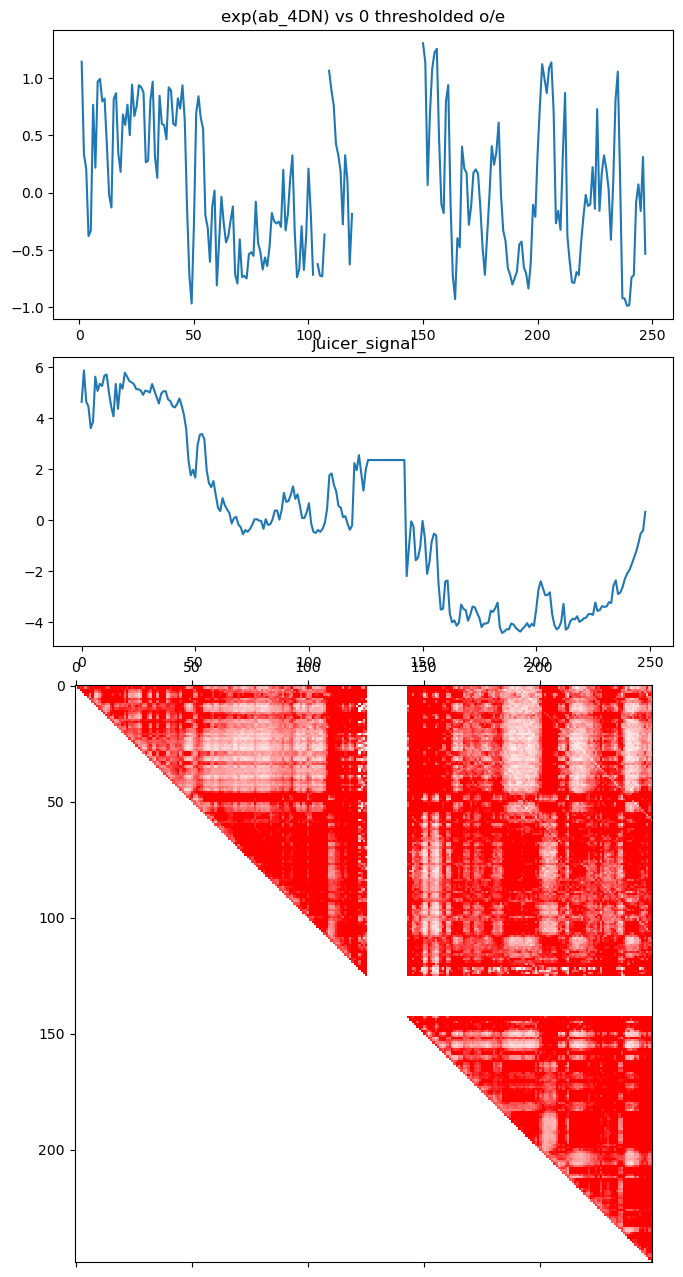

In [6]:
def plot_2dhic_1dtrack_map(dense_matrix, bw_signal, signal, vmin, vmax, cmap):
  d2 = dense_matrix # np.log(dense_matrix)
  d2[np.isnan(d2)] = 0
  d2[np.isinf(d2)] = 0
  fig = plt.figure()
  fig.set_figheight(16)
  fig.set_figwidth(8)
  spec = gridspec.GridSpec(ncols=1, nrows=3,
                         width_ratios=[1], wspace=1,
                         hspace=.1, height_ratios=[10, 10, 20])
  ax0 = fig.add_subplot(spec[0])
  ax0.plot(np.arange(len(bw_signal)), bw_signal)
  plt.title("exp(ab_4DN) vs 0 thresholded o/e")
  ax1 = fig.add_subplot(spec[1])
  ax1.plot(np.arange(len(signal)), signal)
  plt.title("juicer_signal")
  ax2 = fig.add_subplot(spec[2])
  ax2.matshow(d2, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()

# Custom colormap
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])

## single chr visualisation ##
plot_2dhic_1dtrack_map(oe_numpy_thresholded, bw_signal, ab_score, 0, 1, REDMAP) #can replace ab_score with juicer_signal to test correlation

/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_22991/2869988745.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(


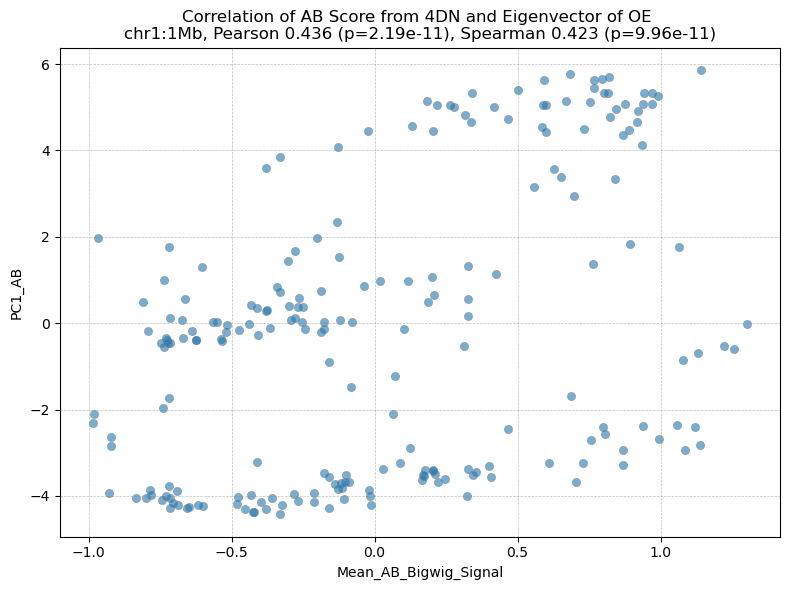

In [7]:
def plot_ab_score_correlation_scatter(correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p, chrom, res_str):
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(
        data=correlation_data, 
        x='Mean_AB_Bigwig_Signal', 
        y='PC1_AB', 
        palette={False: 'green', True: 'red'}, 
        legend='full',
        edgecolor='grey',  # Grey borders
        alpha=0.6
    )
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    handles, labels = scatter.get_legend_handles_labels()
    plt.title(f'Correlation of AB Score from 4DN and Eigenvector of OE \n{chrom}:{res_str}, Pearson {pearson_corr:.3f} (p={pearson_p:.2e}), Spearman {spearman_corr:.3f} (p={spearman_p:.2e})')
    plt.xlabel('Mean_AB_Bigwig_Signal')
    plt.ylabel('PC1_AB')
    plt.tight_layout()
    plt.show()

#correlation between score and signal
correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p = query.ab_comp.ab_score_correlation(ab_score, bw_signal)
#plot
plot_ab_score_correlation_scatter(correlation_data, pearson_corr, pearson_p, spearman_corr, spearman_p, chrom, current_res_str)

## TADs